# Training Phase-2 (U-Net Segmentation Network)

## This network is trained to segment out the prosthesis present in radiograph which will be further used by the segmentation classifier models.

In [33]:
# Install required packages
from distutils.dir_util import copy_tree
copy_tree("D:/Capstone Project/results/lib", "D:/Capstone Project/Working/")
!pip install efficientnet_pytorch

import os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import sys
sys.path.append("D:/Capstone Project/results/lib")

import torch.optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR

In [35]:
from training import load_segmentation_transforms, save_state, cycle_seg

In [36]:
from models import get_unet
from datasets import OrthonetSegmentationDataset

In [37]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CSV_TRAIN_VAL = "D:/Capstone Project/archive/train.csv"
DATA_PATH = "D:/Capstone Project/archive/orthonet data/orthonet data new"
MODEL_DIR = "D:/Capstone Project/Working"

FOLD = 2
BS_TRAIN = 16
BS_VAL = 16
N_WORKERS = 2
N_EPOCHS = 230
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4

In [38]:
# Data
train_transforms, test_transforms = load_segmentation_transforms()
ds_train = OrthonetSegmentationDataset('train', CSV_TRAIN_VAL, DATA_PATH, train_transforms)
ds_val = OrthonetSegmentationDataset('val', CSV_TRAIN_VAL, DATA_PATH, test_transforms)
dl_train = DataLoader(ds_train, BS_TRAIN, shuffle=True, num_workers=N_WORKERS, pin_memory=True)
dl_val = DataLoader(ds_val, BS_VAL, shuffle=True, num_workers=N_WORKERS, pin_memory=True)

print(f"TRAIN")
ds_train.stats()
print(f"VAL")
ds_val.stats()

Found 145 train samples from D:/Capstone Project/archive/train.csv

Found 53 val samples from D:/Capstone Project/archive/train.csv

TRAIN
108 unique patients
Class                                             Number of samples
Hip_SmithAndNephew_Polarstem_NilCol               15
Knee_Depuy_Synthes_Sigma                          13
Knee_SmithAndNephew_GenesisII                     19
Hip_DepuySynthes_Corail_NilCol                    32
Hip_JRIOrtho_FurlongEvolution_Collar              5
Hip_Stryker_Exeter                                23
Hip_DepuySynthes_Corail_Collar                    17
Hip_Stryker_AccoladeII                            11
Hip_SmithAndNephew_Anthology                      5
Hip_JRIOrtho_FurlongEvolution_NilCol              2
Knee_ZimmerBiomet_Oxford                          3


VAL
33 unique patients
Class                                             Number of samples
Knee_SmithAndNephew_GenesisII                     5
Hip_SmithAndNephew_Anthology                     

In [15]:
# Model

from matplotlib import pyplot
model = get_unet(n_in=1, n_out=1).to(DEVICE)
optimizer = torch.optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE*10, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)
criterion = nn.BCEWithLogitsLoss()

# Train
best_dice, best_path, last_save_path = 0, None, None

print(f"Training U-NET")
for epoch in range(1, N_EPOCHS + 1):
    train_loss, train_acc, train_dice = cycle_seg('train', model, dl_train, DEVICE, epoch, criterion, optimizer, scheduler)
    val_loss, val_acc, val_dice = cycle_seg('test', model, dl_val, DEVICE, epoch, criterion, optimizer)
    x = val_dice.value
    def find_Jaccard(x):
        J= x/(2-x)
        return J
    
    find_Jaccard(x)
 

    print(f"Epoch {epoch:03d}\t\t\tTRAIN loss: {train_loss:.4f}\tTRAIN Dice: {train_dice.value:.4f}\tVAL loss: {val_loss:.4f}\tVAL dice: {x:.4f}{'*' if x > best_dice else ''}\tJaccard Index: {find_Jaccard(x):.4f}")

    state = {'epoch': epoch + 1,
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(),
             'scheduler': scheduler}
    save_path = os.path.join(MODEL_DIR, f"seg_unet_{epoch}_{val_dice.value:.07f}.pt")
    best_dice, last_save_path = save_state(state, save_path, val_dice.value, best_dice, last_save_path, lowest_best=False)

Training U-NET
Epoch 001			TRAIN loss: 0.5549	TRAIN Dice: 0.4133	VAL loss: 0.7165	VAL dice: 0.0983*	Jaccard Index: 0.0517
Epoch 002			TRAIN loss: 0.4690	TRAIN Dice: 0.6250	VAL loss: 0.6795	VAL dice: 0.2315*	Jaccard Index: 0.1309
Epoch 003			TRAIN loss: 0.4317	TRAIN Dice: 0.7029	VAL loss: 0.5088	VAL dice: 0.2419*	Jaccard Index: 0.1376
Epoch 004			TRAIN loss: 0.3872	TRAIN Dice: 0.7341	VAL loss: 0.4316	VAL dice: 0.1416	Jaccard Index: 0.0762
Epoch 005			TRAIN loss: 0.3805	TRAIN Dice: 0.7482	VAL loss: 0.3819	VAL dice: 0.4185*	Jaccard Index: 0.2646
Epoch 006			TRAIN loss: 0.3462	TRAIN Dice: 0.7933	VAL loss: 0.3339	VAL dice: 0.7234*	Jaccard Index: 0.5666
Epoch 007			TRAIN loss: 0.3447	TRAIN Dice: 0.7282	VAL loss: 0.3417	VAL dice: 0.8048*	Jaccard Index: 0.6734
Epoch 008			TRAIN loss: 0.3215	TRAIN Dice: 0.7715	VAL loss: 0.3120	VAL dice: 0.6987	Jaccard Index: 0.5369
Epoch 009			TRAIN loss: 0.3308	TRAIN Dice: 0.7582	VAL loss: 0.3185	VAL dice: 0.6031	Jaccard Index: 0.4317
Epoch 010			TRAIN loss: 0

NameError: name 'history' is not defined

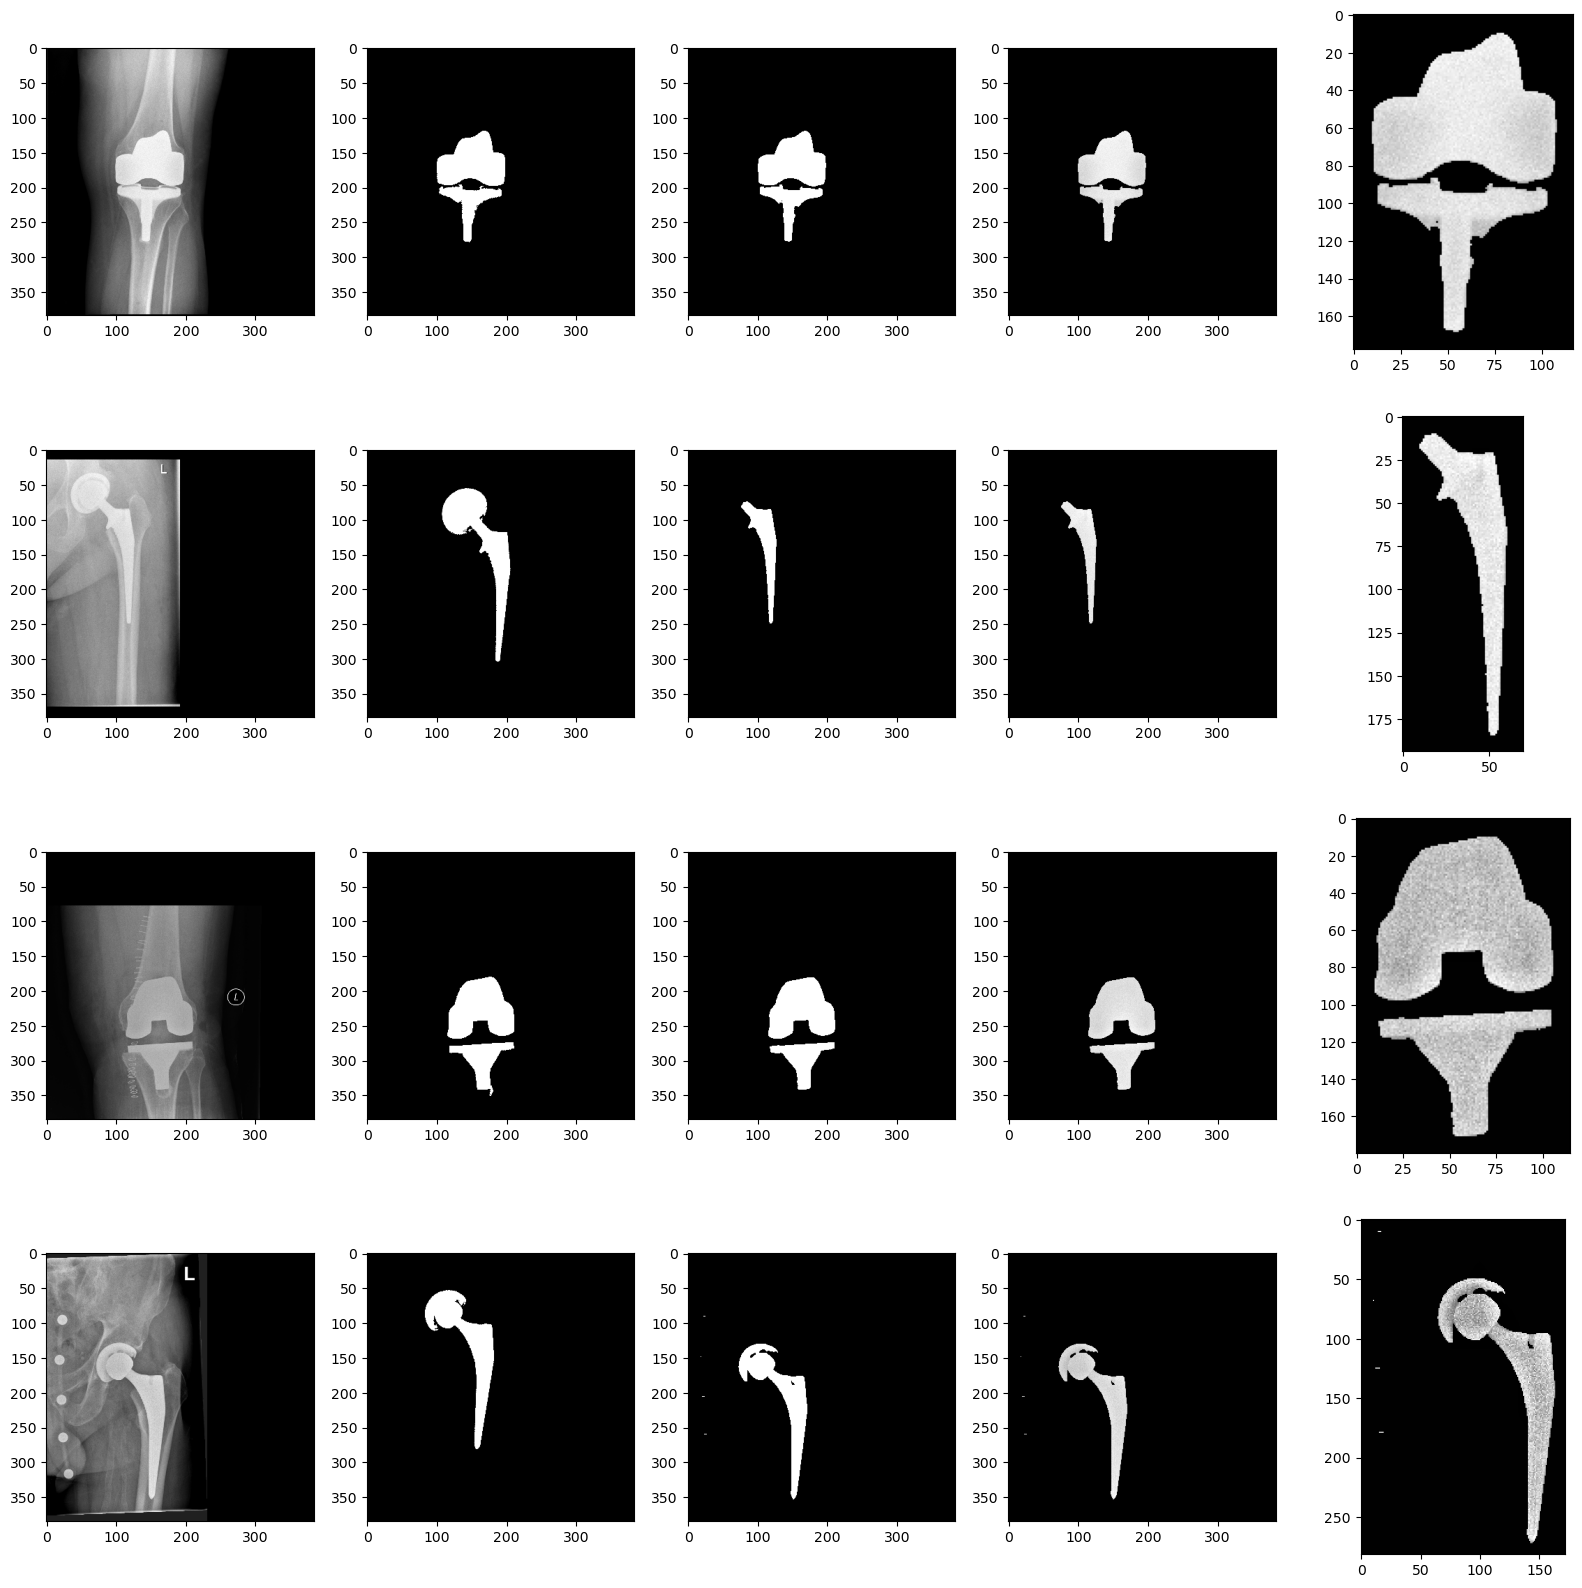

In [56]:
model.load_state_dict(torch.load(last_save_path)['state_dict'])


x_batch, y_true_batch, filepaths, label_names = next(iter(dl_val))
with torch.no_grad():
    y_pred_batch = model(x_batch).cpu().numpy() > 0.5

adaptive_hist = A.Compose([A.CLAHE(p=1)])
fig, axes = plt.subplots(4, 5, figsize=(20,20))

for i, (x, y_true, y_pred, filepath, label_name) in enumerate(zip(x_batch, y_true_batch, y_pred_batch, filepaths, label_names)):
   
    img_masked = x[0].cpu().numpy().copy()
    img_masked[~y_pred[0]] = 0
    
    # Crop & adaptive thresholding
    rows = np.any(y_pred[0], axis=1)
    cols = np.any(y_pred[0], axis=0)
    row_from, row_to = np.where(rows)[0][[0, -1]]
    col_from, col_to = np.where(cols)[0][[0, -1]]
    row_from = max(row_from-10, 0)
    row_to = min(row_to+10, img_masked.shape[-2])
    col_from = max(col_from-10, 0)
    col_to = min(col_to+10, img_masked.shape[-1])
    img_cropped = img_masked[row_from:row_to, col_from:col_to]
    img_equalised = adaptive_hist(image=(img_cropped*255).astype(np.uint8))['image']

    i_row = i
    axes[i_row, 0].imshow(x[0], cmap='gray')
    axes[i_row, 1].imshow(y_true[0], cmap='gray')
    axes[i_row, 2].imshow(y_pred[0], cmap='gray')
    axes[i_row, 3].imshow(img_masked, cmap='gray')
    axes[i_row, 4].imshow(img_equalised, cmap='gray')
    if i >= 3:
        break
plt.show()